# Face Recognition Project

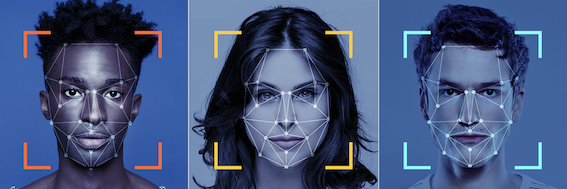

In this project we'll dive into face recognition framework and train neural network for face recognition task, play with losses and metrics.  

We will train neural network on [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). 

As you see on the site, images of celebA dataset look like this:


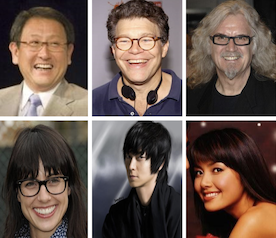

But we won't train a neural network for face recognition on those images. We'll need to preprocess them first. Let's see why we need it and how we need to preprocess them.

Let's look at how face recognition systems work:

## Face Recognition Model Training and Inference Setup

This section describes how face recognition models are trained, what data alignment is and how the inference of face recognition model looks like.

### Model Training

To train face recognition model on any facial dataset images must be aligned first. This step is very important to achieve a good quality of face recognition.

What is alignment: it consists of three steps:
1. Given image, identify facial landmarks on the image (coordinates of eyes, nose and mouth points). Separate neural network can be used there which was trained to identify landmarks on facial images. You can refer to [PyTorch Landmarks tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) to see how this works.
2. Rotate all the images in the dataset so that eyes of the person on every image lie on a certain pre-defined horizontal line.
3. Scale all the images in the dataset so that the size of the faces are approximately identical.

Here's an example of what we would get after alignment of all the images of Aaron Peirsol from our dataset:

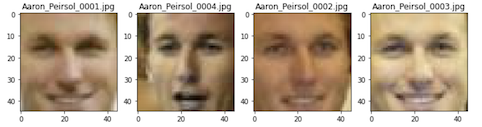

We see that eyes of all the faces lie on one horizontal line and all the faces have almost the same size. If we align all the images in the dataset, we can then train a neural network on aligned images.

**Why we need the alignment procedure**: the alignment of all faces in dataset makes the task of facial recognition easier for the model. If all the faces that model sees are of the same size and have their landmarks (eyes, nose, etc) on almost the same parts of the images, it is easier for the model to learn to identify a person on the image. The model diesn't need to "search" for the face and eyes positions on the image befire performing a recognition.  

The only company that has openly presented its face recognition system that does not require special alignment is Facebook — their neural network was trained on a really huge amount of data using a special trick to avoid alignment. You can read more details [here](https://research.fb.com/publications/deepface-closing-the-gap-to-human-level-performance-in-face-verification/)

### Model Inference

So let's see how the model trained on aligned faces can be used in real world:

Let's assume you owe a company and you want to build a face recognition system for your working office. You decided to hang some cameras around the office and want them to be able to recognize faces of all your employees when they are sitting / walking around the office (we let you decide by yourself why you would need such a system in your office)


A system for face recognition typically conststs of 3 stages:
- face detection
- face alignment
- face recognition

Let's discuss them in detail:

**Face detection**

When the camera is hanged on the wall it records a video and splits the video into single images, like this:

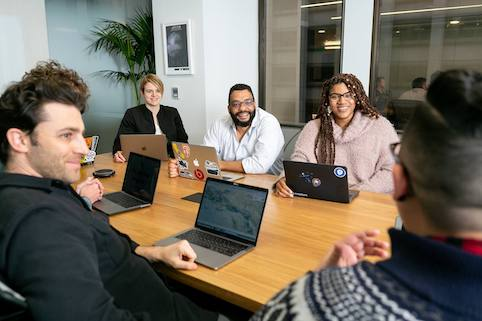

To be able to recognize all the faces on the photo you need first to detect all the faces that are present on the photo, like this:

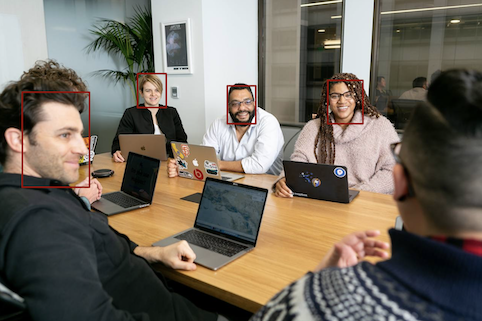

That is the first part — detection. You could use any neural network that can detect humans for this.

**Face alignment**

The second stage is to align all the faces found. The alignment procedure here should be the same as used to align training images.

So we'll get an image of a guy on a photo aligned like this:

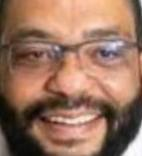

**Face recognition**

On the third stage we use the neural network that we trained to recognize a face.

So that's how the face recognition models pipeline work. You can also read about it more on [this link](https://www.nytimes.com/wirecutter/blog/how-facial-recognition-works/) (and using internet search)

## Neural Network Model Architecture 

Let's discuss how model for face recognition should look like.



The easiest and, actually, the most used way to build a neural network for face recognition is to build it as a **simple classifier**.

Assume we have a dataset with photos of N different people. Then we can build a neural network to classify all the images from the dataset into N classes. Each class refers to one unique person in the dataset.

**How do we recognize new people by this network then?** We actually want the network for face recognition to be able to recognize not only the people which are in training set, but almost every person in the world.

That is how: after training the model, we'll drop it's last classification layer. After that when we'll pass an image of the person through network, we'll get the output of the pre-last layer — it's **the embedding of the image**. Having embeddings of two different images we can compare them using **cosine distance**. The less the distance is — the higher the probability that those two photos belong to one person is. 

Using that technique we can get embeddings of every image — even of unseen people, compare them, and reveal images belonging to same people. 

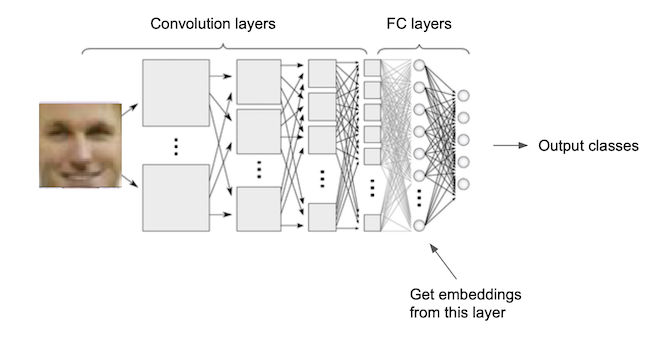

## Building a Neural Network for Faces Classification

### Dataset 

We will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). But we'll use a version of it that has all the images in it aligned and cropped. You can download the dataset using this link: https://disk.yandex.ru/d/S8f03spLIA1wrw

In [ ]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.ru/d/S8f03spLIA1wrw) -o celebA_train.zip
! unzip -qq celebA_train.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  162M  100  162M    0     0  14.8M      0  0:00:10  0:00:10 --:--:-- 22.1M


Let's look at the data first:

In [ ]:
! ls celebA_train_500/

celebA_anno.txt  celebA_imgs  celebA_train_split.txt


- celebA_imgs — folder with aligned images 
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

<b>Let's import libraries needed:</b>

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from skimage import io, transform

import torch
from torch import nn
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
import torch.optim as optim
from sklearn.metrics.pairwise import cosine_similarity
import torch.nn.functional as F
from tqdm.notebook import tqdm
from tqdm import trange
from IPython.display import clear_output
import torch.nn as nn
import random

from cv2 import imread
from cv2 import imshow
from cv2 import waitKey
from cv2 import destroyAllWindows
from cv2 import CascadeClassifier
from cv2 import rectangle

import math

<b>Let's mount google.drive for saving weights of models:</b>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


Let's visualize some images to understand what we're dealing with:

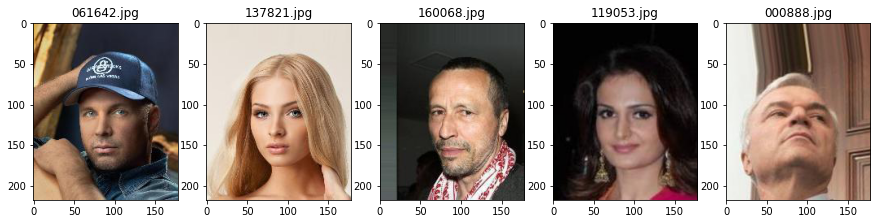

In [ ]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
      img = Image.open(os.path.join('celebA_train_500/celebA_imgs/', img))
      imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()

images_names = os.listdir('./celebA_train_500/celebA_imgs/')[:5]
show_imgs(images_names)

### Train Neural Network

Let's build a Datasets and network using this images:

In [ ]:
def get_paths(dataset_type='train'):
    '''
    a function that returnes list of images paths for a given type of the dataset
    params:
      dataset_type: one of 'train', 'val', 'test'
    '''

    labels_dict = {
        'train': 0,
        'val': 1,
        'test': 2,
    }

    f = open('celebA_train_500/celebA_train_split.txt', 'r')
    lines = f.readlines()
    f.close()

    lines = [x.strip().split() for x in lines]
    lines = [x[0] for x in lines if int(x[1]) == labels_dict[dataset_type]]

    images_paths = []
    for filename in lines:            
        images_paths.append(os.path.join('celebA_train_500/celebA_imgs/', filename))
    
    return np.array(images_paths)


class celebADataset(Dataset):
    """Feel free to rewrite it. For ex. cache all images in RAM to increase training speed"""
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]

        self.transform = transform
        self.aug = aug
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):        
        img_name = self.images[idx]
        label = self.labels[idx]
        
        image = Image.open(img_name) 
        
        if self.aug:
            sample = self.aug(
                image=image,
            )
        else:
            sample = {
                'image': image,
                'label': label,
            }
        
        sample['image'] = self.transform(sample['image'])

        return sample
    
    def get_photos(self, person_number):
        photos = []
        for i, j in enumerate(self.labels):
            if j == person_number:
                photos.append(self.images[i])
        if len(photos) != 0:
            photos = torch.stack([self.transform(Image.open(x)) for x in photos])
        else:
            photos = torch.Tensor()
        return photos

<b>Let's play with various transforms. Because we take neural network pretrained on imagenet (where pictures are 224x224), lets resize and crop our photos for shape needed (224x224):</b>

In [ ]:
transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize(400),
      transforms.Pad((0, 0, 0, 100)),
      transforms.CenterCrop(224),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

transform_aug = transforms.Compose([
      transforms.ToTensor(),
      transforms.Resize(400),
      transforms.Pad((0, 0, 0, 100)),
      transforms.CenterCrop(224),
      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
      transforms.RandomHorizontalFlip(p=0.7),
])

train_data = celebADataset('train', transform)
val_data = celebADataset('val', transform)
test_data = celebADataset('test', transform)

batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)


train_data_aug = celebADataset('train', transform_aug)

train_all_data_aug = torch.utils.data.ConcatDataset([train_data, train_data_aug])
train_loader_aug = torch.utils.data.DataLoader(train_all_data_aug, batch_size=batch_size, shuffle=True)

<b>Let's see the images in our dataloaders:</b>

In [ ]:
def show_images(loader):
    
    images = next(iter(loader))['image']
    
    plt.figure(figsize=(20, 15))
    
    for i in range(6):
        plt.subplot(1, 6, i+1)
        plt.imshow(np.rollaxis((torch.sigmoid(images[i])).numpy(), 0, 3))
        

    plt.show()

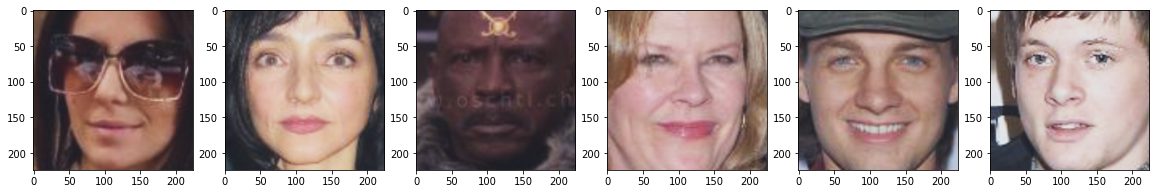

In [ ]:
show_images(train_loader)

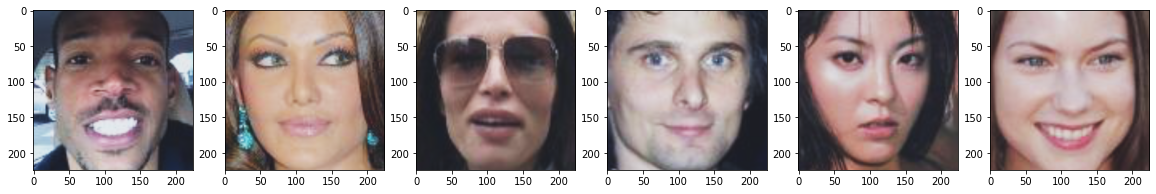

In [ ]:
show_images(train_loader_aug)

<b>Let's see how much photos do we have:</b>

In [ ]:
print('train', len(train_data))
print('train_aug', len(train_all_data_aug))
print('val', len(val_data))
print('test', len(test_data))
print('train_load', len(train_loader))
print('val_load', len(val_loader))
print('test_load', len(test_loader))

train 8544
train_aug 17088
val 1878
test 1589
train_load 267
val_load 59
test_load 50


**Workflow**: let's train a model on train_data using val_data for validation and use standard CE loss, then calculate the loss and accuracy on test set after training. 

Our methodology excludes the utilization of pre-trained models trained on datasets other than ImageNet.

We'll need to drop the last layer after training and get image embeddings from the pre-last layer.

<b>Let's implement train cycles here:</b>

In [ ]:
def train_epoch(model, dataloader, loss_fn, opt):
    
    losses = []

    num_correct = 0
    num_elements = 0

    model.train()

    for i, batch in enumerate(dataloader):
        
        X_batch, y_batch = batch['image'], batch['label']
        num_elements += len(y_batch)

        opt.zero_grad()
        logits = model(X_batch.to(device))
        loss = loss_fn(logits, y_batch.to(device))
        loss.backward()
        opt.step()
        losses.append(loss.item())
        y_pred = torch.argmax(logits, dim=1)
        num_correct += torch.sum(y_pred.cpu() == y_batch)
    
    train_accuracy = num_correct / num_elements
    train_losses = np.mean(losses)
            
    return train_losses, train_accuracy.numpy()

In [ ]:
def eval_epoch(model, dataloader, loss_fn):
    
    losses = []

    num_correct = 0
    num_elements = 0

    model.eval()

    for i, batch in enumerate(dataloader):
        
        X_batch, y_batch = batch['image'], batch['label']
        num_elements += len(y_batch)
        
        with torch.no_grad():
            logits = model(X_batch.to(device))
            
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())
            
            y_pred = torch.argmax(logits, dim=1)
            
            num_correct += torch.sum(y_pred.cpu() == y_batch)
    
    val_accuracy = num_correct / num_elements
    val_losses = np.mean(losses)
            
    return val_losses, val_accuracy.numpy()

In [ ]:
def train(train_loader, val_loader, model, epochs):

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        loss_fn = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = train_epoch(model, train_loader, loss_fn, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, loss_fn)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

<b>I tried many models (among them vgg16, resnet50, efficientnet_v2_s - all pretrained on imagenet) and results were no good, so i take simple resnet18 and it worked out! Wow!</b>

In [ ]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<b>Lets change the last linear layer and add batchnorm as we are asked it in this task. We have 500 classes so the last layer should have 500 out features:</b>

In [ ]:
model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=1000, bias=True),
    nn.BatchNorm1d(1000),
    nn.Linear(in_features=1000, out_features=500, bias=True)
)

<b>Take Adam as optimizer and CE loss</b>

In [ ]:
opt = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<b>Throw our model to cuda:</b>

In [ ]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
history = train(train_loader_aug, val_loader, model=model, epochs=30)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

loss 4.62626204195987

Epoch 001 train_loss: 4.6263     val_loss 4.1308 train_acc 0.1249 val_acc 0.1864
loss 2.3486876458710944

Epoch 002 train_loss: 2.3487     val_loss 2.5376 train_acc 0.4431 val_acc 0.4345
loss 1.3178582687056466

Epoch 003 train_loss: 1.3179     val_loss 2.1076 train_acc 0.6598 val_acc 0.5362
loss 0.7543146142296577

Epoch 004 train_loss: 0.7543     val_loss 2.1051 train_acc 0.7945 val_acc 0.5666
loss 0.46270161473684096

Epoch 005 train_loss: 0.4627     val_loss 1.9071 train_acc 0.8697 val_acc 0.6299
loss 0.3809441624606928

Epoch 006 train_loss: 0.3809     val_loss 2.2755 train_acc 0.8865 val_acc 0.6076
loss 0.27979915176103176

Epoch 007 train_loss: 0.2798     val_loss 2.1167 train_acc 0.9146 val_acc 0.6347
loss 0.2779866787046892

Epoch 008 train_loss: 0.2780     val_loss 2.3697 train_acc 0.9163 val_acc 0.5980
loss 0.27755998355887607

Epoch 009 train_loss: 0.2776     val_loss 2.3042 train_acc 0.9153 val_acc 0.6171
loss 0.1952007450215686

Epoch 010 train_loss

In [ ]:
train_loss, train_acc, val_loss, val_acc = zip(*history)

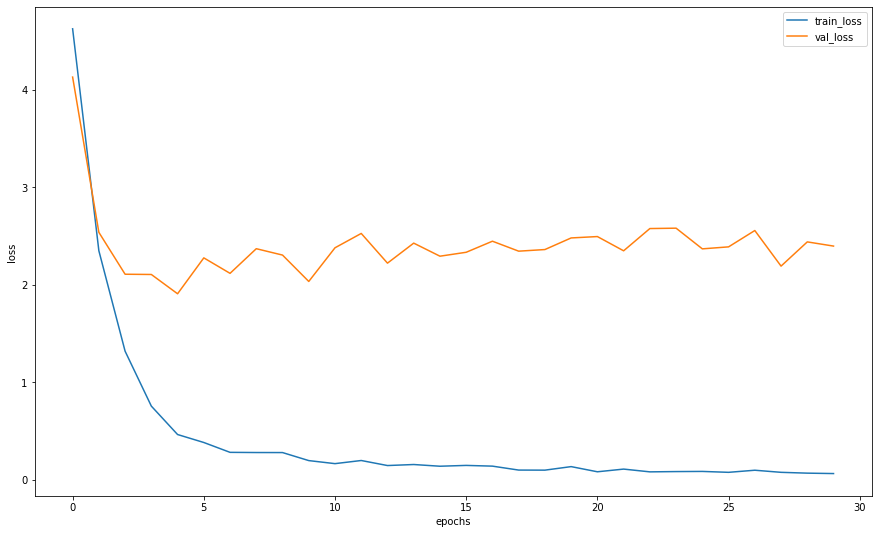

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

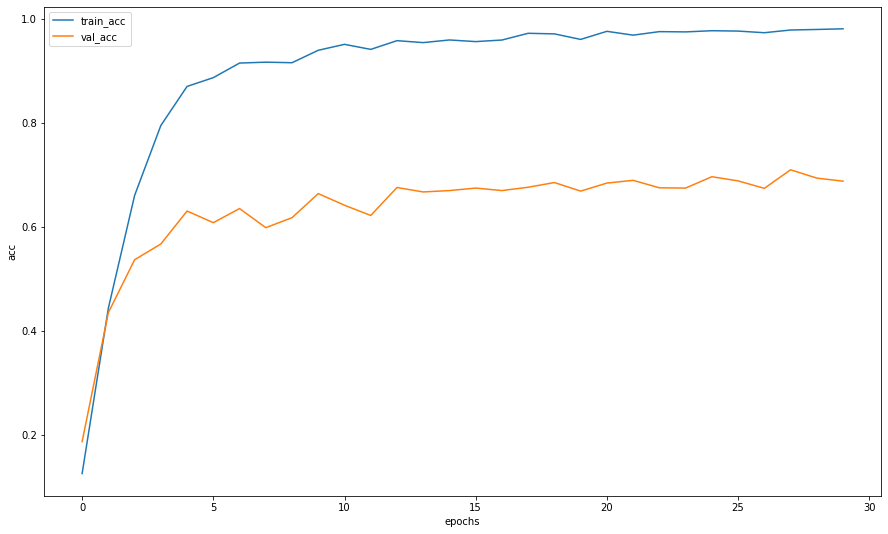

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(train_acc, label="train_acc")
plt.plot(val_acc, label="val_acc")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.show()

<b>We can see above that 30 epochs are enough for accuracy required.</b>

Code for model evaluating:

In [ ]:
def evaluate(model, dataloader, loss_fn):
    
    losses = []

    num_correct = 0
    num_elements = 0

    model.eval()

    for i, batch in enumerate(dataloader):
        
        X_batch, y_batch = batch['image'], batch['label']
        num_elements += len(y_batch)
        
        with torch.no_grad():
            logits = model(X_batch.to(device))
            
            loss = loss_fn(logits, y_batch.to(device))
            losses.append(loss.item())
            
            y_pred = torch.argmax(logits, dim=1)
            
            num_correct += torch.sum(y_pred.cpu() == y_batch)
    
    accuracy = num_correct / num_elements
            
    return accuracy.numpy(), np.mean(losses)

<b>Let's save the model weights just in case:</b>

In [ ]:
checkpoint = {
'model': model,
'state_dict': model.state_dict(),
'optimizer': opt.state_dict()
}

In [ ]:
torch.save(checkpoint, "/content/gdrive/MyDrive/model.pth")

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint("/content/gdrive/MyDrive/model.pth")

In [ ]:
test_accuracy, test_loss = evaluate(model, test_loader, loss_fn)

In [ ]:
test_accuracy

array(0.7073631, dtype=float32)

<b>Yeah! We achived good accuracy (0.7) after dozens of attempts!</b>

In [ ]:
test_loss

2.312316210269928

**Cosine similarity calculation**: let's drop the last layer of trained network and get embeddings for some images from train set and for images from test set, then calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people.

<b>Let's delete the last linear layer as required:</b>

In [ ]:
del model.fc[-1]

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
model.eval()
with torch.no_grad():
    # person number 101 from train data
    p_101 = model(train_data.get_photos(101).to(device))
    # person number 101 from test data
    p_101_t = model(test_data.get_photos(101).to(device))
    # another person number 401 from test data
    p_401 = model(test_data.get_photos(401).to(device))

In [ ]:
print(cosine_similarity(p_101.cpu(), p_101_t.cpu()).mean())
print(cosine_similarity(p_101.cpu(), p_401.cpu()).mean())

0.65871555
0.072883084


<b>We can see the big differencies between cousine similarity of 1  person (person 101 - 0.66) and 2 different persons (person 101 and person 401 - 0.07). Its cool!</b>

**Cosine similarity distribution**: let's calculate all the cosine similarities between images in test dataset and train dataset of the same person. This means if we have image of person #106 in test dataset, we need calculate all similarities between this person's embeddings from test dataset and this person's embeddings from train dataset. 

Then also let's do that for pairs of different people. This means if we have image of person #106 in test dataset, we need calculate similarities between this person's embeddings from test dataset and other people embeddings from train dataset.

Then we should isualize (build histograms) the cosine similarities distributions for same and different people.

This calculation may take a long time and memory since it's a lot of pairs. So we can cut the number of pairs which we calculate distances between.

Positive pairs, distances 8589


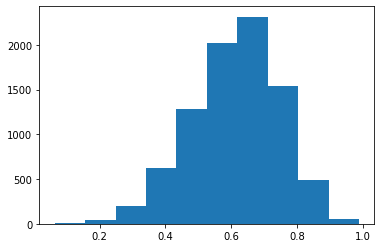

In [ ]:
model.eval()
positive_embeddings = torch.Tensor()
with torch.no_grad():
    for i in range(50):
      x = model(train_data.get_photos(i).to(device))
      myembeddings = pd.DataFrame(cosine_similarity(x.cpu(), x.cpu()))
      myembeddings = myembeddings.mask(np.tril(np.ones(myembeddings.shape, dtype=np.bool_))).values.reshape(-1)
      useful_emb = torch.Tensor(myembeddings[~np.isnan(myembeddings)])
      positive_embeddings = torch.cat((positive_embeddings, useful_emb))
print('Positive pairs, distances', (len(positive_embeddings)))
plt.hist(list(positive_embeddings))
plt.show()

<b>Interesting. The distribution between 0.0 and 1.0 with the peak near 0.7 for positive pairs.</b>

Negative pairs, distances 8122


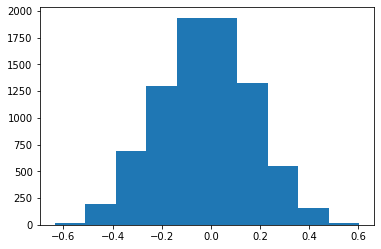

In [ ]:
model.eval()
negative_embeddings = torch.Tensor()
with torch.no_grad():
    for i in range(50):
      x = model(train_data.get_photos(i).to(device))
      x2 = model(train_data.get_photos(i+5).to(device))
      myembeddings = pd.DataFrame(cosine_similarity(x.cpu(), x2.cpu()))
      myembeddings = myembeddings.mask(np.tril(np.ones(myembeddings.shape, dtype=np.bool_))).values.reshape(-1)
      useful_emb = torch.Tensor(myembeddings[~np.isnan(myembeddings)])
      negative_embeddings = torch.cat((negative_embeddings, useful_emb))
print('Negative pairs, distances', (len(negative_embeddings)))
plt.hist(list(negative_embeddings))
plt.show()

<b>For negative pairs we could see another picture: the distribution between -0.6 and 0.6 and the peak is in 0.0</b>

# Identificaton Rate Metric

When training the model above we used CE loss on val and test set as a measure of performance of our model. But this has a major disadvantage: we can't measure how good a model would work on unseen faces (which are not present in training, val & test sets)

To address this we can calculate another metric for the model: **identification rate**. This is how it works:

We have two sets of faces: query and distractors. None of the faces from those sets are present in train, val or test sets. What do we need:

* Calculate cosine similarities between all the faces corresponding to the same people from query dataset. This means if the person has 3 photos in query part: 01.jpg, 02.jpg, 03.jpg, then calculate 3 cosine similarities between every pair of embeddings corresponding to those photos. 
* Calculate cosine similarities between all the faces corresponding to the different people from query dataset. 
* Calculate cosine similarities between all the pairs of embeddings corresponding to query and distractors. This means calculate similarities between pairs (q, d), where q is the embedding that corresponds to a face from query, d — embedding that corresponds to a face from distractors. You'll get |query|*|distractors| similarities.
* Sum numbers of similarities from 2 and 3 stages. This is a number of false pairs.
* Fix **FPR** (false positive rate). Let it be 0.01 in our case. FPR multiplied by a number of false pairs from the stage 4 is the number of false positives we would allow our model to make. Let's call this number N
* Sort all the similarities of false pairs by descending order. Get the Nth element from the beginning — that's our **threshold similarity**.
* Calculate how many positive similarities from stage 1 are equal or more that threshold. Divide this number by whole number of positive similarities from stage 1. This is TPR (true positive rate) — our metric.

This metric can also be expressed as TPR@FPR=0.01. FPR can vary. 

Datasets (query photos, query labels & distructors photos) we can download using the code below:

In [ ]:
! curl -L $(yadisk-direct https://disk.yandex.com/d/KN4EEkNKrF_ZXQ) -o celebA_ir.zip
! unzip -qq celebA_ir.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 8978k  100 8978k    0     0  2242k      0  0:00:04  0:00:04 --:--:-- 5073k


Let's implement the TPR@FPR metric and calculate it for our model and test dataset on FPR=[0.5, 0.2, 0.1, 0.05].

In [ ]:
from collections import defaultdict

f = open('./celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
query_img_names = ['./celebA_ir/celebA_query/{}'.format(x[0]) for x in query_lines]

query_dict = defaultdict(list)
for img_name, img_class in query_lines:
  query_dict[img_class].append(img_name)

distractors_img_names = ['./celebA_ir/celebA_distractors/{}'.format(x) for x in os.listdir('./celebA_ir/celebA_distractors')]

In [ ]:
print(len(distractors_img_names))
print(len(query_img_names))
print(len(query_dict))

2001
1222
51


In [ ]:
class celebA_ir_Dataset(Dataset):
    def __init__(self, images_list, 
                 transform=transforms.Compose([
                                              transforms.ToTensor(),
                                              transforms.Resize(400),
                                              transforms.Pad((0, 0, 0, 100)),
                                              transforms.CenterCrop(224),
                                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                               ])):
        self.images = images_list
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def get_tensors(self):        
        images = torch.stack([self.transform(Image.open(img_name)) for img_name in self.images])
        return images

    def __getitem__(self, idx):        
        img_name = self.images[idx]
        image = Image.open(img_name) 
        
        return self.transform(image), idx

In [ ]:
def compute_embeddings(model, images_list):
  '''
  In this function we compute embeddings from the trained model for list of images.
  params:
    model: trained nn model that takes images and outputs embeddings
    images_list: list of images paths to compute embeddings for
  output:
    list: list of model embeddings. Each embedding corresponds to images 
          names from images_list
  '''
  data = celebA_ir_Dataset(images_list)
  
  model.to(device)

  loader = torch.utils.data.DataLoader(data.get_tensors(), batch_size=32, shuffle=False)

  model.eval()
  embeddings = []
  with torch.no_grad():
      for x in loader:
          outputs = model(x.to(device))
          embeddings.append(outputs.cpu())
  return torch.cat(embeddings)

In [ ]:
query_embeddings = compute_embeddings(model, query_img_names)
distractors_embeddings = compute_embeddings(model, distractors_img_names)

In [ ]:
distractors_embeddings.size(), query_embeddings.size()

(torch.Size([2001, 1000]), torch.Size([1222, 1000]))

In [ ]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
  '''
  In this function we compute cosine similarities between positive pairs from query (stage 1)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding 
                    to the same people from query list
  '''
  for person_class in query_dict:
      if query_dict[person_class][0] not in query_img_names:
          PATH = './celebA_ir/celebA_query/{}'
      else:
          PATH = '{}'
      break

  full_embeddings = torch.Tensor()

  for person_class in query_dict:
      images = [PATH.format(x) for x in query_dict[person_class]] 
      person_embeddings = []
      for image_path in images:
          person_embeddings.append(
              torch.Tensor(query_embeddings[query_img_names.index(image_path)])
              )
      if len(person_embeddings) == 0:
          person_embeddings = torch.Tensor
          result = 0.0
      else:
          person_embeddings = torch.stack(person_embeddings)
          result = cosine_similarity(np.array(person_embeddings), np.array(person_embeddings))
          df = pd.DataFrame(result)
          
          df = df.mask(np.tril(np.ones(df.shape, dtype=np.bool_))).values.reshape(-1)
          useful_result = df[~np.isnan(df)] # drop nan

          useful_result = torch.Tensor(useful_result).view(-1)
          full_embeddings = torch.cat((full_embeddings, useful_result))
  results = [i.item() for i in full_embeddings]
  plt.hist(results)
  plt.show()
  print('Count of cosine similarities =', len(results))
  return results

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
  '''
  In this function we compute cosine similarities between negative pairs from query (stage 2)
  params:
    query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                the dataset. Value: images corresponding to that class
    query_img_names: list of images names
    query_embeddings: list of embeddings corresponding to query_img_names
  output:
    list of floats: similarities between embeddings corresponding 
                    to different people from query list
  '''
  for person_class in query_dict:
      if query_dict[person_class][0] not in query_img_names:
          PATH = './celebA_ir/celebA_query/{}'
      else:
          PATH = '{}'
      break

  full_embeddings = torch.Tensor()
  class_counter = []

  k = 0
  for person_class in query_dict:
      k += 1
      print('Analyse {} person of {}...'.format(k, len(query_dict)))
      images = [PATH.format(x) for x in query_dict[person_class]] 
      class_counter.extend([person_class for i in range(len(images))])

      person_embeddings = []
      for image_path in images:
          person_embeddings.append(
                torch.Tensor(query_embeddings[query_img_names.index(image_path)])
          )
      if len(person_embeddings) == 0:
          person_embeddings = torch.Tensor
          result = 0.0
      else:
          person_embeddings = torch.stack(person_embeddings)
          full_embeddings = torch.cat((full_embeddings, person_embeddings))
      clear_output(wait=True)

  all_data = pd.DataFrame(data={'class': class_counter, 'embeddings': list(full_embeddings)})
  results = cosine_similarity(full_embeddings, full_embeddings)
  results = pd.DataFrame(data=results, index=class_counter, columns=class_counter)

  k = 0
  for i in results:
      k += 1
      print('Analyse {} row of {}...'.format(k, len(results)))
      results.loc[i, i] = np.nan
      clear_output(wait=True)

  df = results.mask(np.tril(np.ones(results.shape, dtype=np.bool_))).values.reshape(-1)
  useful_result = df[~np.isnan(df)] # drop nan
  plt.hist(useful_result)
  plt.show()
  print('Count of cosine similarities =', len(useful_result))
  return useful_result

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
  '''
  In this function we compute cosine similarities between negative pairs from query and distractors
  (stage 3)
  params:
    query_embeddings: list of embeddings corresponding to query_img_names
    distractors_embeddings: list of embeddings corresponding to distractors_img_names
  output:
    list of floats: similarities between pairs of people (q, d), where q is 
                    embedding corresponding to photo from query, d —
                    embedding corresponding to photo from distractors
  '''
  results = cosine_similarity(query_embeddings, distractors_embeddings)
  results = results.reshape(-1)
  plt.hist(results)
  plt.show()
  print('Count of cosine similarities =', len(results))
  return results

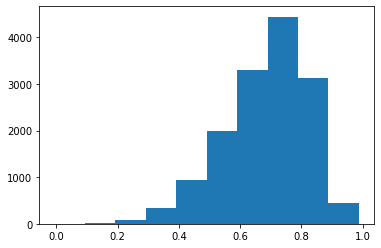

Count of cosine similarities = 14721


In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, 
                                            query_embeddings)

<b>We count this distribution for the same classes, so the peak (0.75) is closer to 1 and the distribution is from 0.0 to 1.0.</b>

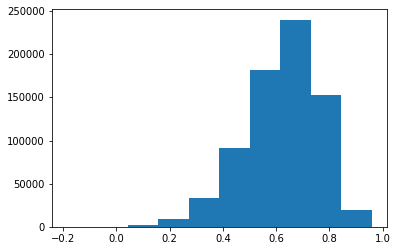

Count of cosine similarities = 731310


In [ ]:
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, 
                                            query_embeddings)

<b>We count this distribution for all classes, so there is another peak (0.65) and the distribution is from -0.2 to 0.95. And i think there is a possibility that in this dataset there are many similar people (for the model).</b>

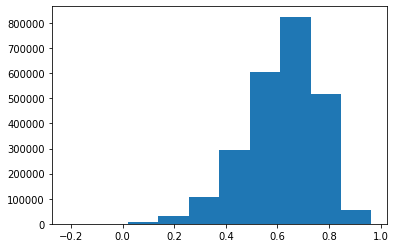

Count of cosine similarities = 2445222


In [ ]:
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, 
                                                            distractors_embeddings)

<b>I think, in distractors dataset there could be filled with many of similar (or the same) persons.</b>

Check our code of functions which compute similarities:

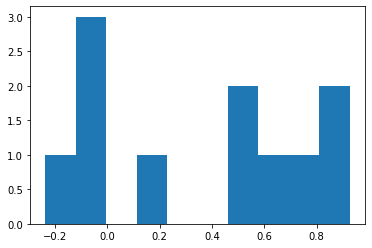

Count of cosine similarities = 11


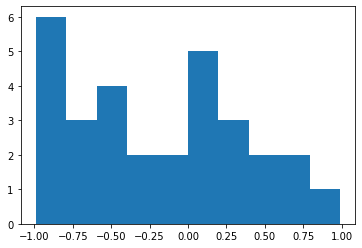

Count of cosine similarities = 30


In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names, 
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names, 
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings, 
                                                            test_distractors_embeddings)

In [ ]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

Let's implement the final function: identification rate calculation

In [ ]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, 
               fpr=0.1):
  '''
  compute identification rate using precomputer cosine similarities between pairs
  at given fpr
  params:
    cosine_query_pos: cosine similarities between positive pairs from query
    cosine_query_neg: cosine similarities between negative pairs from query
    cosine_query_distractors: cosine similarities between negative pairs 
                              from query and distractors
    fpr: false positive rate at which to compute TPR
  output: 
    float: threshold for given fpr 
    float: TPR at given FPR
  '''
  cosine_query_pos = torch.Tensor(cosine_query_pos)
  cosine_query_neg = torch.Tensor(cosine_query_neg)
  cosine_query_distractors = torch.Tensor(cosine_query_distractors)

  false_pairs = torch.cat((cosine_query_neg, cosine_query_distractors))
  N = round(fpr * len(false_pairs))
  false_pairs = torch.sort(false_pairs, descending = True)[0]
  threshold = false_pairs[N]
  TPR = len(cosine_query_pos[cosine_query_pos > threshold]) / len(cosine_query_pos)
  return threshold.item(), TPR

Check ourselves:

In [ ]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
  x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg, 
                    test_cosine_query_distractors, fpr=fpr)
  test_thr.append(x)
  test_tpr.append(y)

In [ ]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

Let's finally compute tpr for faces query and distractors dataset and fpr = [0.5, 0.2, 0.1, 0.05]:

In [ ]:
all_thr = []
all_tpr = []

for fpr in [0.5, 0.2, 0.1, 0.05]:
    print('Analyse by fpr = {}'.format(fpr))
    x, y = compute_ir(cosine_query_pos, cosine_query_neg, 
                      cosine_query_distractors, fpr=fpr)
    all_thr.append(x)
    all_tpr.append(y)
    clear_output(wait=True)

print(all_thr)
print(all_tpr)

[0.6370195150375366, 0.741919994354248, 0.7867878675460815, 0.8191501498222351]
[0.6765844711636437, 0.3856395625297194, 0.24869234427009035, 0.16208138034100944]


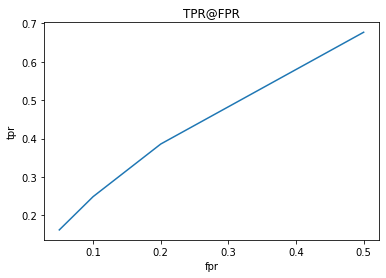

In [ ]:
sns.lineplot(data=pd.DataFrame({'tpr': all_tpr, 'fpr': [0.5, 0.2, 0.1, 0.05]}), x='fpr', y='tpr')
plt.title('TPR@FPR');

<b>It seems not perfect, because the scale of Y and X are not the same. But i definetely see that it is much better than random classifier =)</b>

# Loss functions

Building a network in paragraph 1 we used an ordinary CE loss. But there are many more variants of loss functions that can be used to train neural network. We will discuss two of them, which are the most popular. More examples of losses for face recognition and their performance reviews you can find in this paper: https://arxiv.org/pdf/1901.05903.pdf

## TripletLoss

This is another kind of loss which does not require a model to have last classification layer — it works directly with embeddings. It requires by design to make embeddings of one person be close on embeddings space and embeddings of different people be far away from each other. 

This loss has an advantage over CE-like losses: it does not rely on number of classes in dataset. If we have new faces of new people in a dataset, we won't need to completely retrain the network, we could just fine-tune the trained network on new photos.


**How TripletLoss works**:

Here the architecture of neural network will be slightly different than it was when we used CE loss: it won't have the last classification layer. The last layer of NN will output embeddings of the given photo. 

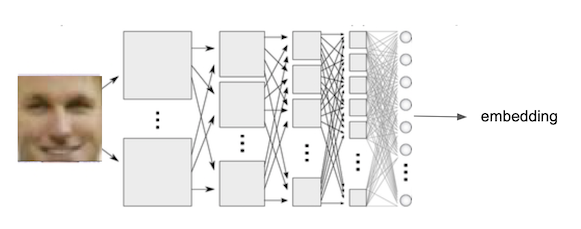

The TripletLoss function works directly with these embeddings. The idea of it is to make embeddings of the same people more close, compact in the embedding space, and the embeddings of the different people be more separate. There's a formula for the loss:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

where 
- $e$ is embedding of a photo (output of a model)
- $p$ is a positive embedding for the photo (embedding that we want $e$ be close to)
- $n$ is a negative embedding for the photo (embedding that we want $e$ be far from)
- $d(x, y)$ is a distance measure between embeddings 
- margin — a positive margin to further boost the difference between $d(a, p)$ and $d(a, n)$

**All the embeddings $e$, $p$ and $n$ must be normalized before passing them to the loss**.

In our case for the given photo $E$ and it's embedding $e$ positive embedding $p$ must be an embedding of the photo of the same person and embedding $n$ must be an ambedding of the photo of the different person.

This emplementation of TripletLoss for PyTorch can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss). There are different variants of TripletLoss which can also boost performance and which you can implement by yourself, if you want:
- use more that 1 sample of $p$ and $n$ for one embedding $e$ 
- use special kinds of negatives: e.g. the negatives that are the most close to e (to boost them be further away from e)


**More to read about TripletLoss**:

The idea of TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss

PyTorch implementation of TripletLoss: https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss

Now let's implement a model and train it with TripletLoss.

<b>Let's take our lovely resnet18, but rewrite it with batchnorm in the end of linear layer:</b>

In [ ]:
TripletLoss_model = models.resnet18(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
TripletLoss_model.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=1000, bias=True),
    nn.BatchNorm1d(1000),
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<b>Let's code function for face detection:</b>

In [ ]:
def detectFace(img):
    opencv_image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR) 
    faces = face_detector.detectMultiScale(opencv_image, 1.3, 5)

    if len(faces) > 0:
        face = faces[0]
        face_x, face_y, face_w, face_h = face
        opencv_image = opencv_image[int(face_y):int(face_y+face_h), int(face_x):int(face_x+face_w)]

        color_coverted = cv2.cvtColor(opencv_image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(color_coverted)
        return pil_image
    
    return img

opencv_home = cv2.__file__
folders = opencv_home.split(os.path.sep)[0:-1]

path = folders[0]
for folder in folders[1:]:
    path = path + "/" + folder

face_detector_path = path+"/data/haarcascade_frontalface_default.xml"

if os.path.isfile(face_detector_path) != True:
    raise ValueError("Confirm that opencv is installed on your environment! Expected path ",detector_path," violated.")

face_detector = cv2.CascadeClassifier(face_detector_path)

<b>Let's rewrite celebadataset class for triplet loss:</b>

In [ ]:
class Triplet_celebADataset(Dataset):
    def __init__(self, dataset_type, transform, aug=None,):
        self.images = get_paths(dataset_type=dataset_type)

        f = open('celebA_train_500/celebA_anno.txt', 'r')
        labels = f.readlines()
        f.close()
        labels = [x.strip().split() for x in labels]
        labels = {x:y for x, y in labels}
        self.labels = [int(labels[x.split('/')[-1]]) for x in self.images]
        self.transform = transform
        self.aug = aug
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        classes = np.arange(len(self.labels)-1)
        positive_class, negative_class = np.random.choice(classes, size=2)

        anchor_img = self.images[positive_class]
        anchor_label = self.labels[positive_class]
        
        pos_label = self.labels[positive_class+1]
        if pos_label != anchor_label:
            pos_img = self.images[positive_class-1]
            pos_label = self.labels[positive_class-1]
        else:
            pos_img = self.images[positive_class+1]
        
        neg_img = self.images[negative_class]
        neg_label = self.labels[negative_class]
        
        image_anchor = Image.open(anchor_img)
        image_neg = Image.open(neg_img)
        image_pos = Image.open(pos_img)
        
        face_anchor = detectFace(image_anchor)
        face_neg = detectFace(image_neg)
        face_pos = detectFace(image_pos)
        
        sample = {
            'anchor': self.transform(face_anchor),
            'anchor_label': anchor_label,
            
            'positive': self.transform(face_pos),
            'positive_label': pos_label,
            
            'negative': self.transform(face_neg),
            'negative_label': neg_label,
        }
        
        return sample

In [ ]:
def train_triplet(model, optimizer, criterion, n_epochs, train_loader, val_loader):
    valid_loss_min = np.Inf
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for batch in tqdm(train_loader):
            optimizer.zero_grad()
            anchor, anchor_label, pos_img, pos_label, neg_img, neg_label = \
                    batch['anchor'], batch['anchor_label'], batch['positive'], batch['positive_label'], batch['negative'], batch['negative_label']

            anchor = model(anchor.to(device))
            positive = model(pos_img.to(device))
            negative = model(neg_img.to(device))

            loss = criterion(anchor, positive, negative)
            loss.backward()

            optimizer.step()
            train_loss += loss.item()*anchor.size(0)

        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_loader):
                anchor, anchor_label, pos_img, pos_label, neg_img, neg_label = \
                    batch['anchor'], batch['anchor_label'], batch['positive'], batch['positive_label'], batch['negative'], batch['negative_label']

                anchor = model(anchor.to(device))
                positive = model(pos_img.to(device))
                negative = model(neg_img.to(device))
                loss = criterion(anchor, positive, negative)
                valid_loss += loss.item()*anchor.size(0)

        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(val_loader.sampler)
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(embedding.state_dict(), 'model_best_weights.pt')
            valid_loss_min = valid_loss

In [ ]:
batch_size = 32

In [ ]:
triplet_train_data = Triplet_celebADataset('train', transform_aug)
triplet_val_data = Triplet_celebADataset('val', transform)
triplet_test_data = Triplet_celebADataset('test', transform)

triplet_train_loader = torch.utils.data.DataLoader(triplet_train_data, batch_size=batch_size, shuffle=True)
triplet_val_loader = torch.utils.data.DataLoader(triplet_val_data, batch_size=batch_size, shuffle=False)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_data, batch_size=batch_size, shuffle=False)

In [ ]:
embedding = TripletLoss_model.to(device)

<b>I tried various margin, best result for 2-4 hours training in google.colab was for margin=0.2:</b>

In [ ]:
lr = 1e-4
criterion = nn.TripletMarginLoss(margin=0.2, p=2)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, TripletLoss_model.parameters()),
    lr=lr)

In [ ]:
n_epochs = 20
train_triplet(embedding, optimizer, criterion, n_epochs, triplet_train_loader, triplet_val_loader)

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.844241 	Validation Loss: 0.943722
Validation loss decreased (inf --> 0.943722).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.631655 	Validation Loss: 0.845133
Validation loss decreased (0.943722 --> 0.845133).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.476124 	Validation Loss: 0.714717
Validation loss decreased (0.845133 --> 0.714717).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.446876 	Validation Loss: 0.787469


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.375166 	Validation Loss: 0.684467
Validation loss decreased (0.714717 --> 0.684467).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.377048 	Validation Loss: 0.658238
Validation loss decreased (0.684467 --> 0.658238).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.331310 	Validation Loss: 0.699293


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.316586 	Validation Loss: 0.683346


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.288808 	Validation Loss: 0.586544
Validation loss decreased (0.658238 --> 0.586544).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.257267 	Validation Loss: 0.655052


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 0.231281 	Validation Loss: 0.626098


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 0.257292 	Validation Loss: 0.630419


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 0.253619 	Validation Loss: 0.568642
Validation loss decreased (0.586544 --> 0.568642).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 0.249351 	Validation Loss: 0.568201
Validation loss decreased (0.568642 --> 0.568201).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 0.210744 	Validation Loss: 0.525539
Validation loss decreased (0.568201 --> 0.525539).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 0.201743 	Validation Loss: 0.535725


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 0.200927 	Validation Loss: 0.617245


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 0.180325 	Validation Loss: 0.551638


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 0.178418 	Validation Loss: 0.611675


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 0.206490 	Validation Loss: 0.683717


In [ ]:
embedding.load_state_dict(torch.load('./model_best_weights.pt'))

<All keys matched successfully>

<b>Save the weights just in case:</b>

In [ ]:
checkpoint = {
'model': embedding,
'state_dict': embedding.state_dict(),
'optimizer': optimizer.state_dict()
}

In [ ]:
torch.save(checkpoint, "/content/gdrive/MyDrive/embedding.pth")

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint("/content/gdrive/MyDrive/embedding.pth")

In [ ]:
def sim_matrix(a, b, eps=1e-8):
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt.cpu().numpy()

<b>Let's create embeddings of train dataset:</b>

In [ ]:
train_labels = []
train_embedding = []

embedding.eval()
with torch.no_grad():
    for batch in tqdm(train_loader):
        image, label = batch['image'].to(device), batch['label']
        img_emb = embedding(image)
        train_embedding.append(img_emb)
        train_labels.append(label)   #store the image name to find it later on

train_labels = [k.item() for i in train_labels for k in i]
train_embedding = [k for i in train_embedding for k in i]
train_embedding = torch.stack((train_embedding))

  0%|          | 0/267 [00:00<?, ?it/s]

In [ ]:
correct_labels = 0
embedding.eval()
with torch.no_grad():
    for batch in tqdm(test_data):
        image, true_label = batch['image'].to(device), batch['label']
        img_emb = embedding(image.unsqueeze(0))
        similarities = sim_matrix(img_emb, train_embedding)
        pred_label = train_labels[similarities.argmax()]
        correct_labels += (np.array(pred_label) == np.array(true_label)).sum()

triplet_accuracy = correct_labels / len(test_data)

  0%|          | 0/1589 [00:00<?, ?it/s]

In [ ]:
triplet_accuracy

0.2983008181246067

<b>0.298. Not as good as i think it should be (higher than 0.7), but i have tried so many ways such as changing the neural network, changing photos from 224x224 to 160x160, learning rate with scheduler, batch_size from 32 to 128, anothers neural networks, another transforms, another margin loss, but 0.3 for 2-3-4 hours training in google.colab is my best result.</b>

<b>Now let's check KNN result.</b>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
k_neighbors = KNeighborsClassifier(n_neighbors=1,n_jobs=-1)

train_labels = []
train_embedding = []

embedding.eval()
with torch.no_grad():
    for batch in tqdm(train_data):
        image, label = batch['image'].to(device), batch['label']
        preds = embedding(image.unsqueeze(0))
        preds = preds.cpu().numpy().flatten()
        train_embedding.append(preds)
        train_labels.append(label)

train_embedding = np.array(train_embedding)

test_labels = []
test_embedding = []
embedding.eval()
with torch.no_grad():
    for batch in tqdm(test_data):
        image, label = batch['image'], batch['label']
    
        test_embed = embedding(image.unsqueeze(0).to(device))
        test_embed = test_embed.cpu().numpy().flatten()
        test_labels.append(label)
        test_embedding.append(test_embed)
        
test_embedding = np.array(test_embedding)
k_neighbors.fit(train_embedding, train_labels)

acc = k_neighbors.score(np.array(test_embedding), test_labels)
print("model accuracy: {:.2f}%".format(acc * 100))

  0%|          | 0/8544 [00:00<?, ?it/s]

  0%|          | 0/1589 [00:00<?, ?it/s]

model accuracy: 30.27%


<b>It's 0.3. The same.</b>

<b>Let's try to further train the model on our mixed train dataset (aug and original) with a larger batch (128) and margin (0.5):</b>

In [ ]:
batch_size = 128
triplet_train_data = Triplet_celebADataset('train', transform)
triplet_val_data = Triplet_celebADataset('val', transform)
triplet_test_data = Triplet_celebADataset('test', transform)

triplet_train_data_aug = Triplet_celebADataset('train', transform_aug)
triplet_train_all_data_aug = torch.utils.data.ConcatDataset([triplet_train_data, triplet_train_data_aug])

triplet_train_loader = torch.utils.data.DataLoader(triplet_train_all_data_aug, batch_size=batch_size, shuffle=True)
triplet_val_loader = torch.utils.data.DataLoader(triplet_val_data, batch_size=batch_size, shuffle=False)
triplet_test_loader = torch.utils.data.DataLoader(triplet_test_data, batch_size=batch_size, shuffle=False)

In [ ]:
lr = 1e-4
criterion = nn.TripletMarginLoss(margin=0.5, p=2)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, TripletLoss_model.parameters()),
    lr=lr)

In [ ]:
checkpoint = {
'model': embedding,
'state_dict': embedding.state_dict(),
'optimizer': optimizer.state_dict()
}

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])

    return model

embedding = load_checkpoint("/content/gdrive/MyDrive/embedding.pth")

In [ ]:
embedding = embedding.to(device)

In [ ]:
lr = 1e-4
criterion = nn.TripletMarginLoss(margin=0.5, p=2)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, TripletLoss_model.parameters()),
    lr=lr)
n_epochs = 10
train_triplet(embedding, optimizer, criterion, n_epochs, triplet_train_loader, triplet_val_loader)

  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 0.237513 	Validation Loss: 0.582358
Validation loss decreased (inf --> 0.582358).  Saving model ...


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 0.231354 	Validation Loss: 0.579434
Validation loss decreased (0.582358 --> 0.579434).  Saving model ...


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 0.209543 	Validation Loss: 0.551571
Validation loss decreased (0.579434 --> 0.551571).  Saving model ...


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 0.237687 	Validation Loss: 0.553295


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.226849 	Validation Loss: 0.639538


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 0.221842 	Validation Loss: 0.545135
Validation loss decreased (0.551571 --> 0.545135).  Saving model ...


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 0.237897 	Validation Loss: 0.584644


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.239482 	Validation Loss: 0.558936


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.235388 	Validation Loss: 0.580951


  0%|          | 0/134 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.228072 	Validation Loss: 0.489651
Validation loss decreased (0.545135 --> 0.489651).  Saving model ...


<b>Hm. Training loss are the same in 10 epochs...</b>

In [ ]:
checkpoint = {
'model': embedding,
'state_dict': embedding.state_dict(),
'optimizer': optimizer.state_dict()
}

In [ ]:
torch.save(checkpoint, "/content/gdrive/MyDrive/embedding_2.pth")

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
k_neighbors = KNeighborsClassifier(n_neighbors=1,n_jobs=-1)

train_labels = []
train_embedding = []

embedding.eval()
with torch.no_grad():
    for batch in tqdm(train_data):
        image, label = batch['image'].to(device), batch['label']
        preds = embedding(image.unsqueeze(0))
        preds = preds.cpu().numpy().flatten()
        train_embedding.append(preds)
        train_labels.append(label)   #store the image name to find it later on

train_embedding = np.array(train_embedding)

test_labels = []
test_embedding = []
embedding.eval()
with torch.no_grad():
    for batch in tqdm(test_data):
        image, label = batch['image'], batch['label']
    
        test_embed = embedding(image.unsqueeze(0).to(device))
        test_embed = test_embed.cpu().numpy().flatten()
        test_labels.append(label)
        test_embedding.append(test_embed)
        
test_embedding = np.array(test_embedding)
k_neighbors.fit(train_embedding, train_labels)

# calculating accuracy with knn
acc = k_neighbors.score(np.array(test_embedding), test_labels)
print("model accuracy: {:.2f}%".format(acc * 100))

  0%|          | 0/8544 [00:00<?, ?it/s]

  0%|          | 0/1589 [00:00<?, ?it/s]

model accuracy: 29.89%


<b>Ahaha. "Not bad". Even a bit worse.</b>

## ArcFace Loss (Additive Angular Margin Loss)

This loss is somewhat "SOTA" for face recognition systems (somewhat — because actually different variants of losses and their combinations may be the best for different network architectures). This loss inherits idea from CE loss but further develops it to achieve better embeddings distribution on a sphere. It introduces some geodesic constraints to enhance intra-class compactness and inter-class discrepancy.



**How ArcFace loss works**:

This loss is a variation of a standard SoftMax CE loss, which enforces embeddings of different classes (people) be further away: have a more sparse representation of embeddings in embedding space, enforce more evident gap between the nearest classes.

The standard SoftMax CE loss for classification task is presented as follows:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

where:
- $x_i \in \mathbb{R^d}$ denotes the deep feature of the $i$-th sample, belonging to the $y_i$-th class;
- $W_j \in \mathbb{R^d}$ denotes the j-th column of the weight;
- $W \in \mathbb{R^d}$ and $b_j \in \mathbb{R^d}$ is the bias term;
- $N$ — batch size;
- $n$ — class number.

It appears, that, though this loss works well, it does not explicitly optimise the feature embedding to enforce higher similarity for intra- class samples and diversity for inter-class samples, which results in a performance gap for deep face recognition under large intra-class appearance variations.

Let's do some work on this loss formula:
- fix the bias $b_j=0$;
- normalize weight ||$W_j$|| = 1;
- normalize embedding ||$x_i$|| = 1 and re-scale it to s (s is a hyperparameter)

The normalisation step on embeddings and weights makes the predictions only depend on the angle between the embedding and the weight. The learned embeddings fare thus distributed on a hypersphere with a radius of s.

So we get the following loss function now:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Final step: let's add an additive angular margin penalty $m$ between $x_i$ and $W_{y_i}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

SO this is an ArcFace loss. It has 2 hyperparameters: s and m.

The original paper to read about ArcFace more precisely: https://arxiv.org/pdf/1801.07698.pdf

The original repo, where you can find a code sample: https://github.com/deepinsight/insightface

Let's implement a model and train it with ArcFace loss.

<b>Let's code arcface class:</b>

In [ ]:
class ArcFace(nn.Module):
    def __init__(self, in_features, out_features, s=64.0, m=0.5, easy_margin=False, ls_eps=0.0):
        super(ArcFace, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_uniform_(self.weight)

        self.easy_margin = easy_margin
        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = math.cos(math.pi - m)
        self.mm = math.sin(math.pi - m) * m

    def forward(self, input, label):
        cosine = F.linear(F.normalize(input), F.normalize(self.weight))
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = torch.where(cosine > 0, phi, cosine)
        else:
            phi = torch.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = torch.zeros(cosine.size(), device=device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.out_features
        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s

        return output

<b>Take our model:</b>

In [ ]:
arcface_model = models.resnet18(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<b>Add "arcface" layer to the model:</b>

In [ ]:
class ArcFace_model(nn.Module):
    def __init__(self):
        super(ArcFace_model, self).__init__()
        
        self.encoding = arcface_model
        self.bn1 = nn.BatchNorm1d(1000)
        self.arcface = ArcFace(1000, 500)

    def forward(self, x, labels=None):
        x = self.encoding(x)
        x = self.bn1(x)
        if labels is not None:
            x = self.arcface(x, labels)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
arcface_model = ArcFace_model().to(device);

In [ ]:
def train(model, optimizer, criterion, n_epochs, train_loader, val_loader):
    valid_loss_min = np.Inf
    for epoch in range(1, n_epochs+1):
        train_loss = 0.0
        valid_loss = 0.0

        model.train()
        for batch in tqdm(train_loader):
            image, label = batch['image'].to(device), torch.as_tensor(batch['label']).to(device)
            optimizer.zero_grad()
            output = model(image, label)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*image.size(0)

        model.eval()
        with torch.no_grad():
            for batch in tqdm(val_loader):
                image, label = batch['image'].to(device), torch.as_tensor(batch['label']).to(device)
                output = model(image, label)
                loss = criterion(output, label)
                valid_loss += loss.item()*image.size(0)

        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(val_loader.sampler)
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))

        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), 'model_best_weights.pt')
            valid_loss_min = valid_loss

In [ ]:
lr = 1e-4
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, arcface_model.parameters()),
    lr=lr)
criterion = nn.CrossEntropyLoss()
n_epochs = 10

train(arcface_model, optimizer, criterion, n_epochs, train_loader, val_loader)

  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 28.850820 	Validation Loss: 31.981280
Validation loss decreased (inf --> 31.981280).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 24.077773 	Validation Loss: 30.546571
Validation loss decreased (31.981280 --> 30.546571).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 18.793591 	Validation Loss: 29.168110
Validation loss decreased (30.546571 --> 29.168110).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 13.177392 	Validation Loss: 27.790423
Validation loss decreased (29.168110 --> 27.790423).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 7.819230 	Validation Loss: 26.816146
Validation loss decreased (27.790423 --> 26.816146).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 3.573411 	Validation Loss: 26.490225
Validation loss decreased (26.816146 --> 26.490225).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 1.111686 	Validation Loss: 26.010272
Validation loss decreased (26.490225 --> 26.010272).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 0.270184 	Validation Loss: 25.627677
Validation loss decreased (26.010272 --> 25.627677).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 0.068608 	Validation Loss: 25.472328
Validation loss decreased (25.627677 --> 25.472328).  Saving model ...


  0%|          | 0/267 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 0.022806 	Validation Loss: 25.325454
Validation loss decreased (25.472328 --> 25.325454).  Saving model ...


In [ ]:
arcface_model.load_state_dict(torch.load('./model_best_weights.pt'))

<All keys matched successfully>

In [ ]:
checkpoint = {
'model': arcface_model,
'state_dict': arcface_model.state_dict(),
'optimizer': optimizer.state_dict()
}

In [ ]:
torch.save(checkpoint, "/content/gdrive/MyDrive/arcface_model.pth")

In [ ]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

arcface_model = load_checkpoint("/content/gdrive/MyDrive/arcface_model.pth")

In [ ]:
train_labels = []
train_embedding = []

arcface_model.eval()
with torch.no_grad():
    for batch in tqdm(train_loader):
        image, label = batch['image'].to(device), batch['label']
        img_emb = arcface_model(image)
        train_embedding.append(img_emb)
        train_labels.append(label)   

train_labels = [k.item() for i in train_labels for k in i]
train_embedding = [k for i in train_embedding for k in i]
train_embedding = torch.stack((train_embedding))

  0%|          | 0/267 [00:00<?, ?it/s]

In [ ]:
correct_labels = 0
arcface_model.eval()
with torch.no_grad():
    for batch in tqdm(test_data):
        image, true_label = batch['image'].to(device), batch['label']
        img_emb = arcface_model(image.unsqueeze(0))
        similarities = sim_matrix(img_emb, train_embedding)
        pred_label = train_labels[similarities.argmax()]
        correct_labels += (np.array(pred_label) == np.array(true_label)).sum()

accuracy = correct_labels / len(test_data)

  0%|          | 0/1589 [00:00<?, ?it/s]

In [ ]:
accuracy

0.6803020767778477

<b>0.68. Not bad. Lets further train a bit this model on our mixed train dataset (aug and original):</b>

In [ ]:
lr = 1e-4
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, arcface_model.parameters()),
    lr=lr)
criterion = nn.CrossEntropyLoss()
n_epochs = 5

train(arcface_model, optimizer, criterion, n_epochs, train_loader_aug, val_loader)

  0%|          | 0/534 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 1 	Training Loss: 7.717398 	Validation Loss: 23.456352
Validation loss decreased (inf --> 23.456352).  Saving model ...


  0%|          | 0/534 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 4.575308 	Validation Loss: 22.149354
Validation loss decreased (23.456352 --> 22.149354).  Saving model ...


  0%|          | 0/534 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 2.612155 	Validation Loss: 21.269848
Validation loss decreased (22.149354 --> 21.269848).  Saving model ...


  0%|          | 0/534 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 1.407063 	Validation Loss: 21.123530
Validation loss decreased (21.269848 --> 21.123530).  Saving model ...


  0%|          | 0/534 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 0.714835 	Validation Loss: 20.903123
Validation loss decreased (21.123530 --> 20.903123).  Saving model ...


In [ ]:
arcface_model.load_state_dict(torch.load('./model_best_weights.pt'))

<All keys matched successfully>

In [ ]:
checkpoint = {
'model': arcface_model,
'state_dict': arcface_model.state_dict(),
'optimizer': optimizer.state_dict()
}

In [ ]:
torch.save(checkpoint, "/content/gdrive/MyDrive/arcface_model.pth")

In [ ]:
train_labels = []
train_embedding = []

arcface_model.eval()
with torch.no_grad():
    for batch in tqdm(train_loader):
        image, label = batch['image'].to(device), batch['label']
        img_emb = arcface_model(image)
        train_embedding.append(img_emb)
        train_labels.append(label)   

train_labels = [k.item() for i in train_labels for k in i]
train_embedding = [k for i in train_embedding for k in i]
train_embedding = torch.stack((train_embedding))

  0%|          | 0/267 [00:00<?, ?it/s]

In [ ]:
correct_labels = 0
arcface_model.eval()
with torch.no_grad():
    for batch in tqdm(test_data):
        image, true_label = batch['image'].to(device), batch['label']
        img_emb = arcface_model(image.unsqueeze(0))
        similarities = sim_matrix(img_emb, train_embedding)
        pred_label = train_labels[similarities.argmax()]
        correct_labels += (np.array(pred_label) == np.array(true_label)).sum()

accuracy = correct_labels / len(test_data)

  0%|          | 0/1589 [00:00<?, ?it/s]

In [ ]:
accuracy

0.7677784770295784

<b>0.77. Lucky number. Yeah! We did it! We beat model with CE loss (we got higher accuracy than 0.7 there)!</b>